# Insert Project Title

## Introduction 
provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
clearly state the question you tried to answer with your project
identify and fully describe the dataset that was used to answer the question


The purpose of this Data Science Project is to perform an analysis to answer a predictive question using the Minecraft server, PlaiCraft, dataset. Specifically, we'd like to better understand the details regarding player engagement and demographics. This dataset was collected by a research group in Computer Science at UBC to explore how people play video games. In this Project Planning Report, a brief data description, proposed question, exploratory data analysis and visualization will be presented along with a structured approach and plan.

### Data Description

 The data being used on this project was collected by having individuals play on UBC's research group's Mincraft served called PlaiCraft. The data collected consisted of information such as player experience, their session durations, and furthmore. The files we are presented with consists of players.csv and sessions.csv.

#### Players Dataset
The players.csv file contains information collected from the Minecraft server with 197 observations and 7 columns. Each observation is representative of a player. 

Further information about the dataset can be seen in the following table:

|  Variable Name | Variable Data Type |                          Description                                | 
|:--------------:|:------------------:|:-------------------------------------------------------------------:|
|  experience    |  Character         |   Describes if a player is a Pro, Veteran, Beginner or Amateur	    |  
|  subscribe     |  Logical           |   Denotes if a player has subscribed to PlaiCraft's email updates   |   
|  hashedEmail   |  Character         |   The hashed email for each player                                  |  
| played_hours   |  Double            |   The total number of hours a player has played                     |
|  name          |  Character         |   The player's alias                                                |  
|  gender        | Character          |   The player's gender, either male or female                        |  
|  age           |  Double            |   The player's age                                                  | 


#### Sessions Dataset
The sessions.csv file contains information collected from the Minecraft server with 1535 observations and 5 columns. Each observation is representative of a player's playing session, noting the start and end times of that session.
Further information about the dataset can be seen in the following table:

|  Variable Name       | Variable Data Type |                          Description                                | 
|:--------------------:|:------------------:|:-------------------------------------------------------------------:| 
|  hashedEmail         |  Character         |   The hashed email for each player                                  |  
|  start_time          |  Character         |   The player's actual start time of the session                     |
|  end_time            |  Character         |   The player's actual end time of the session                       |  
|  original_start_time |  Double            |   The player's scheduled start times in UNIX timestamp format       |  
|  original_end_time   |  Double            |   The player's scheduled end times in UNIX timestamp format         | 

## Question and Methods
The overall question is to discover which “kinds” of players contribute to the most amount of data in order to target those players in recruiting efforts. Specifically, our group would like to predict a player’s playtime based on their age and/or experience level in order to determine what age range or experience levels contribute most to the number of hours played. To do this, we will create a linear regression model to satisfy our prediction. 

# Analysis

## Loading and Wrangling Data

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library (lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_data <- read_csv ("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")|>
    select(-individualId, -organizationName)

sessions_data <- read_csv ("https://drive.google.com/uc?export=download&id=14O91N5OlVkvdGxXNJUj5jIsV5RexhzbB")

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_analysis_data <- sessions_data |> 
    mutate (start_time = as.POSIXct(start_time, format = "%d/%m/%Y %H:%M")) |>
    mutate (end_time = as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))|>
    mutate (converted_end_sec = as.numeric(as.POSIXct(end_time, format = "%d/%m/%Y %H:%M"))) |>
    mutate (converted_start_sec = as.numeric(as.POSIXct(start_time, format = "%d/%m/%Y %H:%M"))) |>
    mutate (duration = (converted_end_sec - converted_start_sec )/(60)) |>
    select (-original_start_time, -original_end_time)|>
    group_by (hashedEmail)|>
    summarize(total_duration_min = sum(duration))

In [4]:
combined_data <- left_join(players_data, players_analysis_data, by="hashedEmail") |>
    mutate(total_duration_min = replace_na(total_duration_min, 0)) |>
    mutate(id_number = row_number())|>
    select (id_number, everything(), - hashedEmail, -name)


In [5]:
head(combined_data) 

id_number,experience,subscribe,played_hours,gender,age,total_duration_min
<int>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>
1,Pro,TRUE,30.3,Male,9,2019
2,Veteran,TRUE,3.8,Male,17,255
3,Veteran,FALSE,0.0,Male,17,5
4,Amateur,TRUE,0.7,Female,21,50
5,Regular,TRUE,0.1,Male,21,9
6,Amateur,TRUE,0.0,Female,17,0


In [6]:
raw_data <- combined_data|>
    mutate(numerical_experience = case_when(
    experience == "Amateur" ~ 1,
    experience == "Beginner" ~ 2,
    experience == "Regular" ~ 3,
    experience == "Pro" ~ 4,
    experience == "Veteran" ~ 5)) |>
    mutate(numerical_gender = case_when(
        gender == "Female" ~ 1,
        gender == "Male" ~ 2,
        gender == "Non-binary" ~ 3, 
        gender == "Agender" ~ 4,
        gender == "Two-Spirited" ~ 5, 
        gender == "Other" ~ 6,
        gender == "Prefer not to say" ~ 7))
           
head(raw_data) 

id_number,experience,subscribe,played_hours,gender,age,total_duration_min,numerical_experience,numerical_gender
<int>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Pro,TRUE,30.3,Male,9,2019,4,2
2,Veteran,TRUE,3.8,Male,17,255,5,2
3,Veteran,FALSE,0.0,Male,17,5,5,2
4,Amateur,TRUE,0.7,Female,21,50,1,1
5,Regular,TRUE,0.1,Male,21,9,3,2
6,Amateur,TRUE,0.0,Female,17,0,1,1


## Filtering Data to Remove Outliers

There are outliers in the data set that can be removed to create a better model. We can visualize the duration played in a histogram to choose a limit to the duration played.

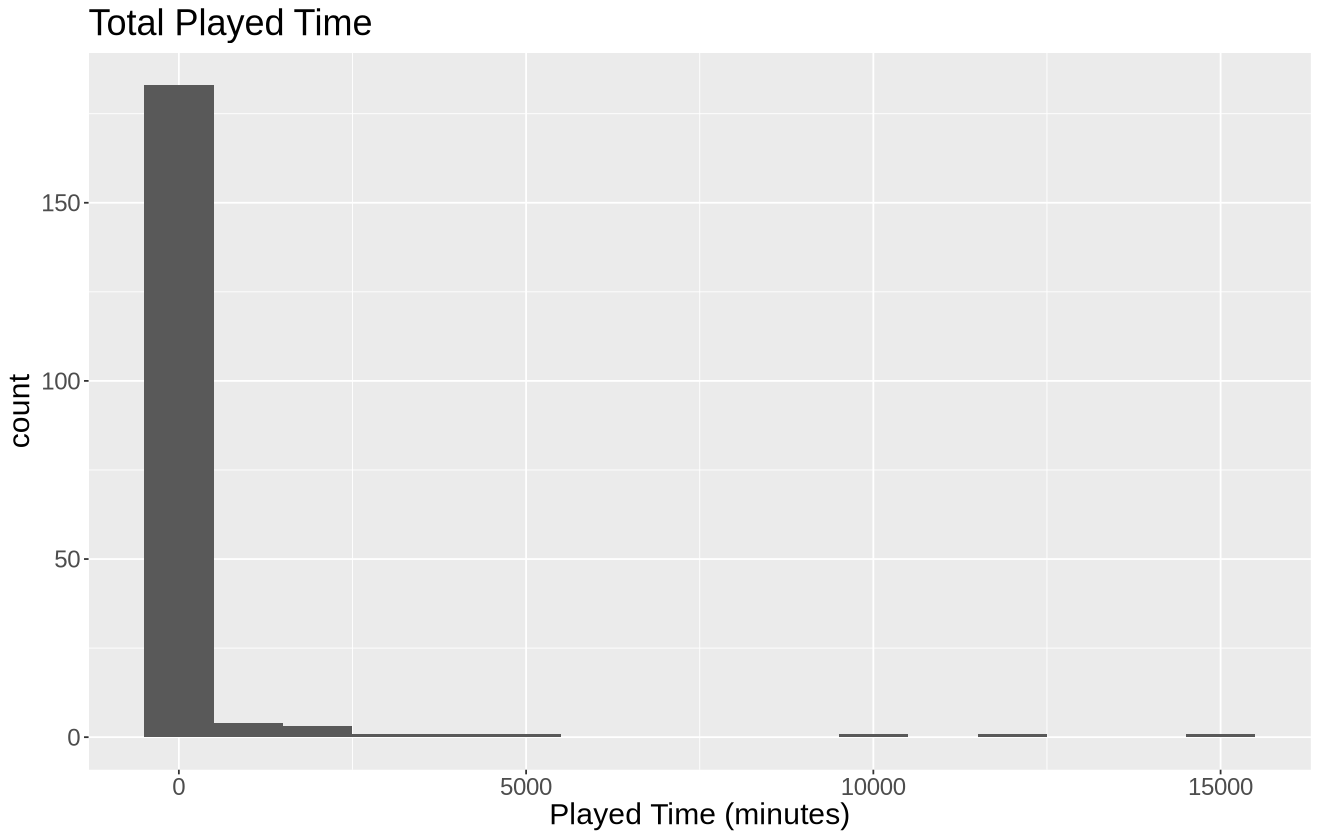

In [7]:
options(repr.plot.width = 11, repr.plot.height = 7)  

Played_time_hist<- raw_data |>
                    ggplot(aes(x = total_duration_min))+
                    geom_histogram(binwidth = 1000) +
                    labs(x = "Played Time (minutes)", title= "Total Played Time") +
                    theme(text = element_text(size = 18)) 
Played_time_hist

Most of the duration played occurs from 0 - 900 minutes as seen in the height of the bars in the histogram. We will set the limit of the duration played to 900 minutes. 

Next we will investigate the outliers for the age of players with a histogram:

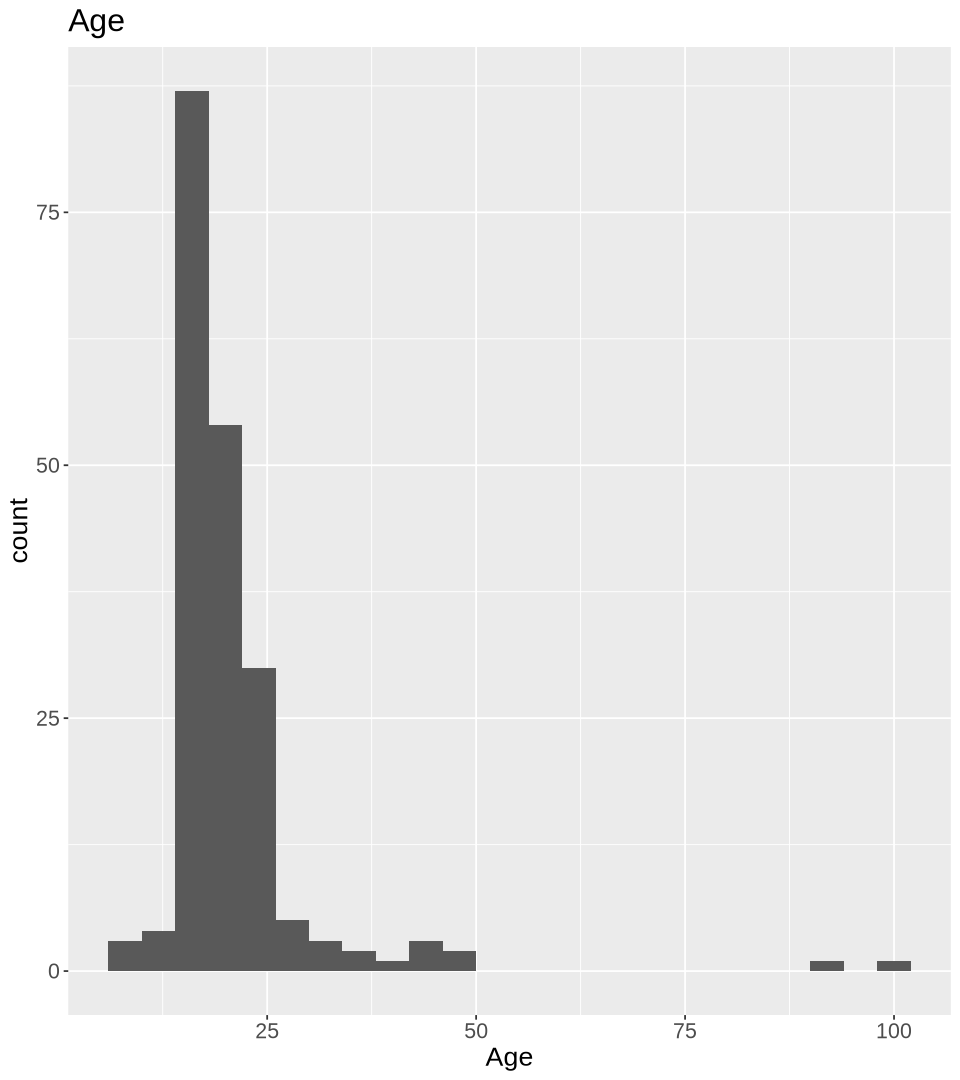

In [8]:
options(repr.plot.width = 8, repr.plot.height = 9) 
Age_hist<- raw_data |>
                    ggplot(aes(x = age))+
                    geom_histogram(binwidth = 4) +
                    labs(x = "Age", title= "Age") +
                    theme(text = element_text(size = 16))
Age_hist

There are two outliers that occur past the age of 50. We will limit the age to 50 years old. 

The data is filtered as follows:

In [9]:
set.seed(2000)
combined_data <- raw_data |>
    filter(age <=50) |> 
    filter(total_duration_min <=900) 


## Splitting the Data Set

To create a linear regression model, we will split the data set into a training and testing set so that cross-validation can be performed and the accuracy of the model can be evaluated.

In [10]:
data_split <- initial_split(combined_data, prop = 0.75, strata = total_duration_min) 

data_training <- training(data_split)
data_testing <- testing(data_split)

## Investigating Relationships with Visualizations

First, we will investigate the relationship between the duration played and the experience level of the player where each experience level is assigned to a numerical value. In the wrangled data above, "Amateur" was given a value of 1, "Beginner" was assigned a value of 2, etc.

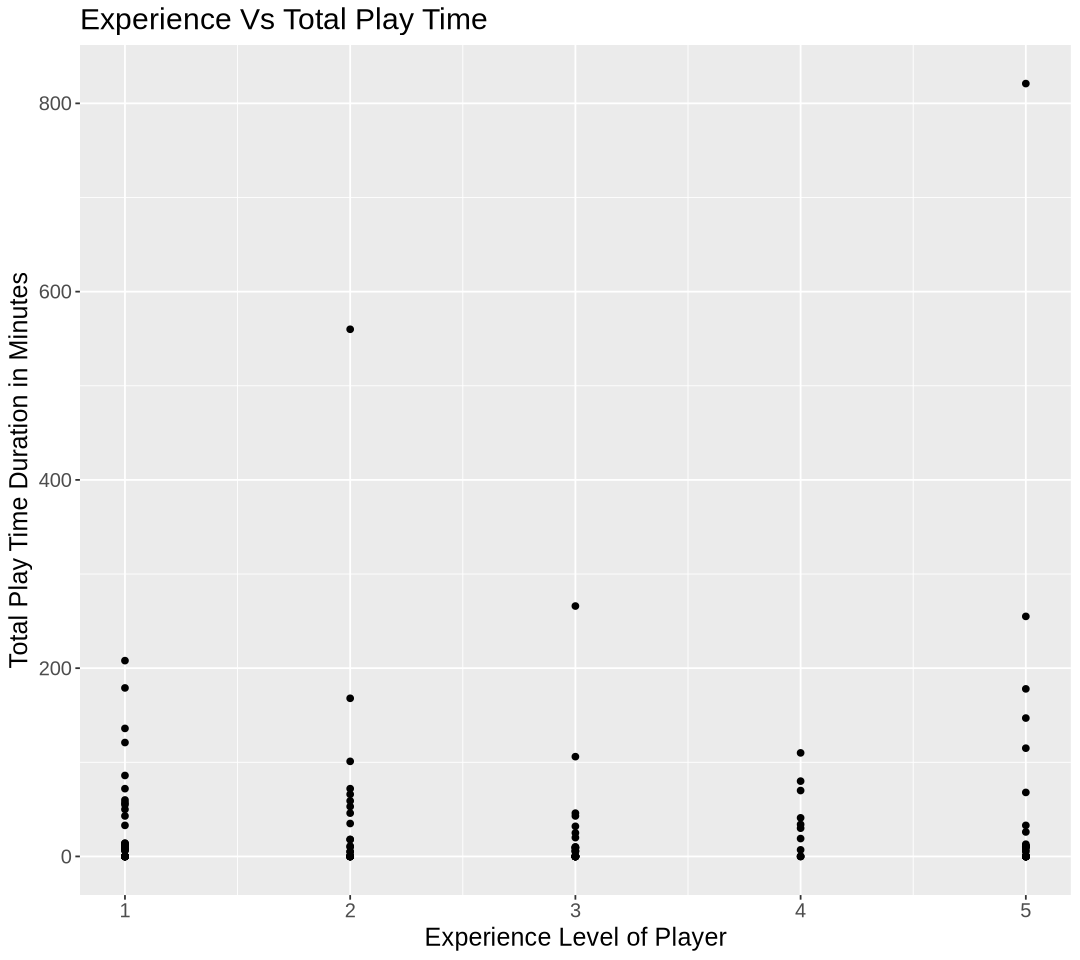

In [11]:
options(repr.plot.width = 9, repr.plot.height = 8) 

raw_training_plot <- data_training |>
    ggplot(aes (x = numerical_experience, y= total_duration_min)) +
    geom_point()+
    labs(x = "Experience Level of Player",
         y = "Total Play Time Duration in Minutes",
        title = "Experience Vs Total Play Time") +
        theme(text = element_text(size = 15))

raw_training_plot

The scatter plot data is not usable as the points are all focused on the integers due to the experience level of the player being a categorical variable. The data does not show a linear relationship and would not be suited for the linear regression model that we want to apply. 

This data would be better represented as a bar graph:

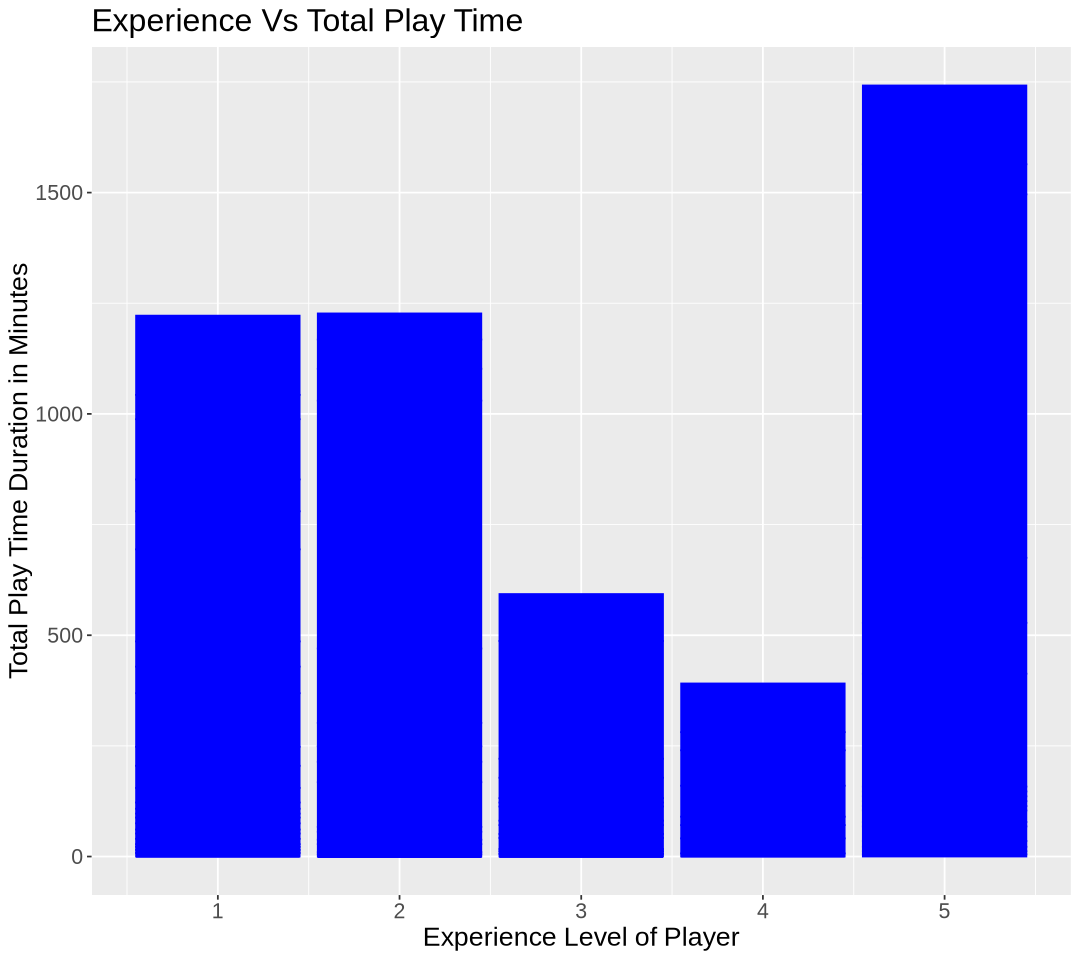

In [12]:
options(repr.plot.width = 9, repr.plot.height = 8) 

raw_training_bar <- data_training |>
    ggplot(aes(x = numerical_experience, y = total_duration_min)) +
    geom_bar(stat = "identity", fill = "blue", color = "blue") +
    labs(x = "Experience Level of Player",
         y = "Total Play Time Duration in Minutes",
         title = "Experience Vs Total Play Time") +
        theme(text = element_text(size= 16))

raw_training_bar

We see a similar result when visualizing the relationship between gender and the time played.

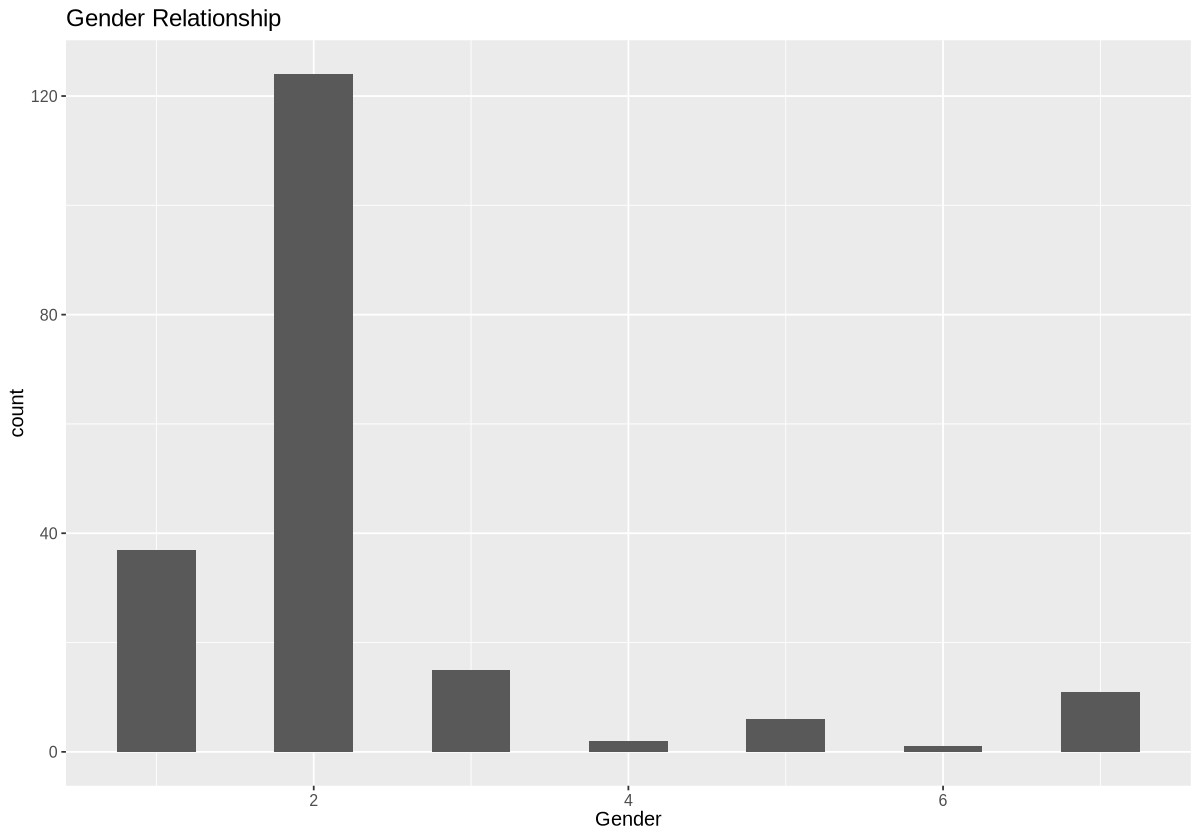

In [13]:
options(repr.plot.width = 10, repr.plot.height = 7)  

 Gender_hist <- raw_data |>
                    ggplot(aes(x = numerical_gender))+
                    geom_histogram(binwidth = 0.5) +
                    labs(x = "Gender", title= "Gender Relationship") +
                    theme(text = element_text(size = 12))

Gender_hist

This histogram helps visualize how Gender is distributed in the data set. Each bin represents a type of Gender. Since Gender is a categorical variable, we assigned it to numbers from 1-7 in order to attempt setting it to a regression type model. Clearly, Gender is not a continuous variable to assess as a regression model because of its discontinuity from deriving from a categorical variable. Therefore, since there are only a fixed amount of variables, there isn’t enough data for Gender to be a variable in our linear regression model and therefore is disregarded. 

Next, we will investigate the relationship between the duration played and age. 

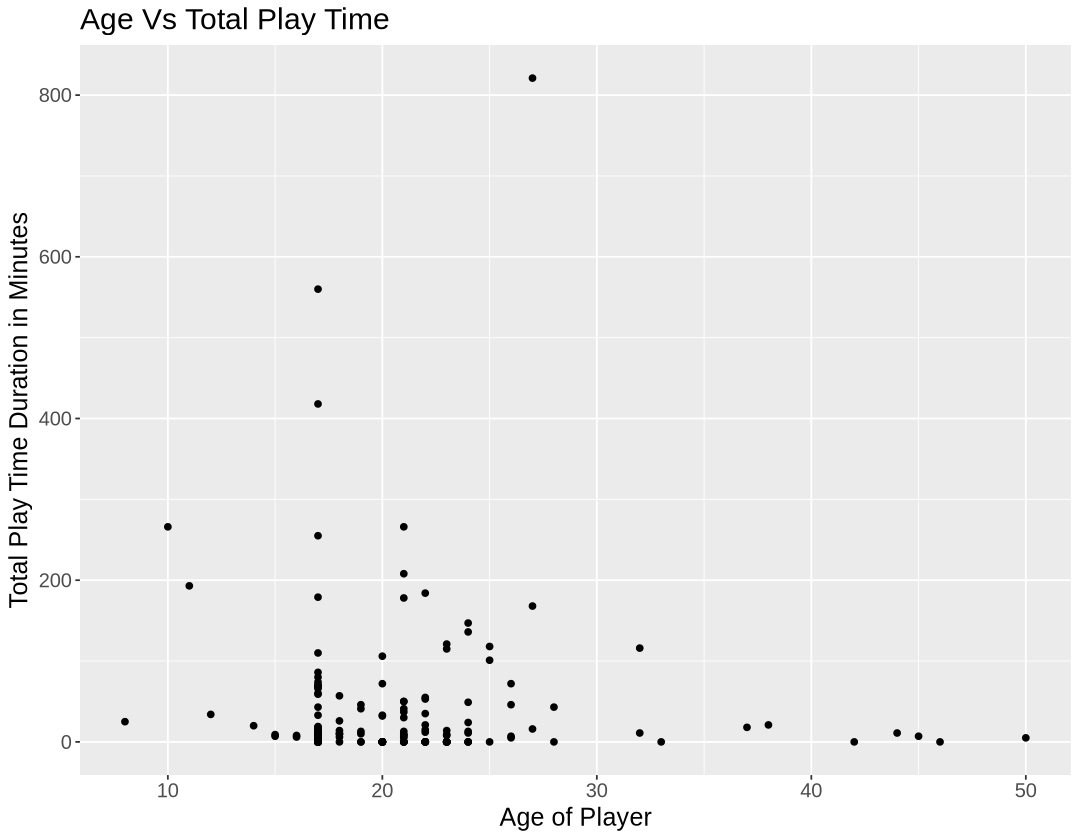

In [14]:
options(repr.plot.width = 9, repr.plot.height = 7) 

raw_training_plot <- combined_data |>
    ggplot(aes (x = age, y= total_duration_min)) +
    geom_point()+
    labs(x = "Age of Player",
         y = "Total Play Time Duration in Minutes",
        title = "Age Vs Total Play Time") +
       theme(text= element_text(size = 15))

raw_training_plot

This plot has a much better spread of data compared to the other variables because the range is greater. While age is still a categorical variable, there is enough of a range of data for the data to display continous properties. Therefore in our model, we will have age as the only predictor variable.

## Regression Model

The data was already split earlier in the analysis. To start, we will build a model only for the training data to allow us to perform cross-validation in later steps. A recipe with age as the predictor variable is added as well as a model specification using the `linear_reg()` function and setting the engine and mode appropriately for regression. The recipe and model specification will them be fitted to the training data set with the `workflow()` function.

In [15]:
lm_recipe <- recipe(total_duration_min ~ age, data = data_training)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode ("regression")

lm_fit <- workflow() |>
      add_recipe(lm_recipe) |>
      add_model(lm_spec) |>
      fit(data = data_training)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
   36.86974      0.05762  


A visualization of the training set with the regression line on the plot of age against time played in minutes is as follows:

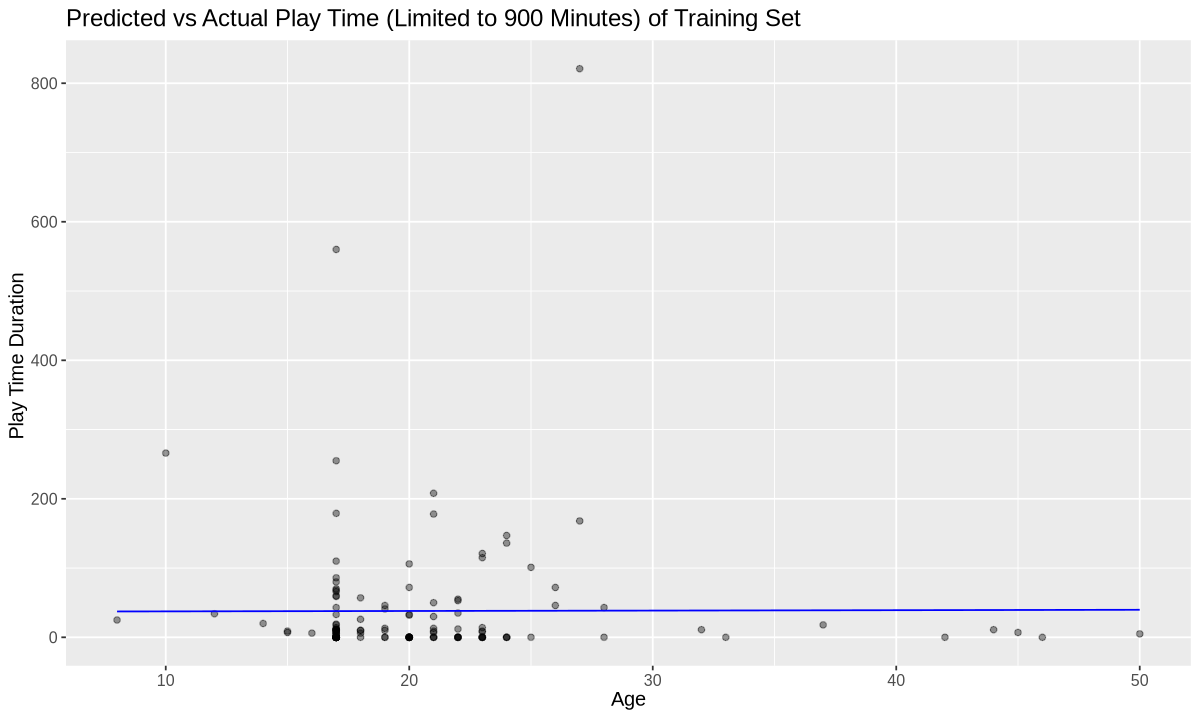

In [16]:
options(repr.plot.width = 10, repr.plot.height = 6) 

data_preds <- lm_fit |>
  predict(data_training) |>
  bind_cols(data_training)

lm_predictions <- data_preds |>
    ggplot(aes(x = age, y = total_duration_min)) +
        geom_point(alpha = 0.4) +
        geom_line(
            mapping = aes(x = age, y = .pred), 
            color = "blue") +
        xlab("Age") +
        ylab("Play Time Duration (Minutes)") +
        ggtitle("Predicted vs Actual Play Time (Limited to 900 Minutes) of Training Set")+
        theme(text = element_text(size = 12))

lm_predictions

We can predict on the test data set to assess how well our model does by finding the RMSPE (root mean squared prediction error).

In [22]:
lm_test_results <- lm_fit |>
        predict(data_testing) |>
        bind_cols(data_testing) |>
        metrics(truth = total_duration_min, estimate = .pred)

lm_rmspe <- lm_test_results |>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()

lm_rmspe

[1] 79.05092

The RMSPE of our model is 79 minutes.

We can also visualize the regression line on the testing data set on a plot of age against played time.

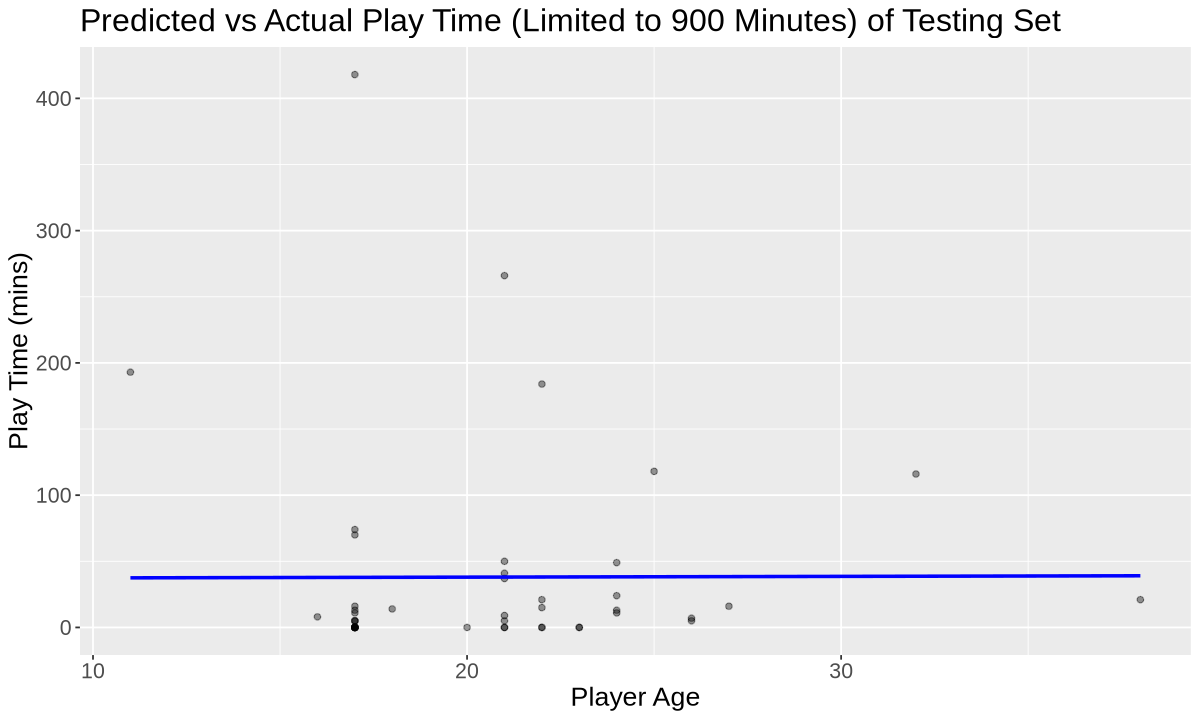

In [23]:
options(repr.plot.width = 10, repr.plot.height = 6) 

test_preds <- lm_fit |> 
    predict(data_testing) |>
    bind_cols(data_testing) 
    
lm_predictions_test <- test_preds |> 
    ggplot(aes (x=age, y = total_duration_min)) +
    geom_point(alpha = 0.4) +
    geom_line(
        data = test_preds, 
        mapping = aes (x = age, y = .pred),
        colour = "blue",
        linewidth = 1) +
    labs(x = "Player Age",
         y = "Play Time (mins)",
        title= "Predicted vs Actual Play Time (Limited to 900 Minutes) of Testing Set") +
        theme(text = element_text(size = 16))

lm_predictions_test

Combining the data together, we can make a plot with all of the data points from the combined data frame and include the regression line made by our model:

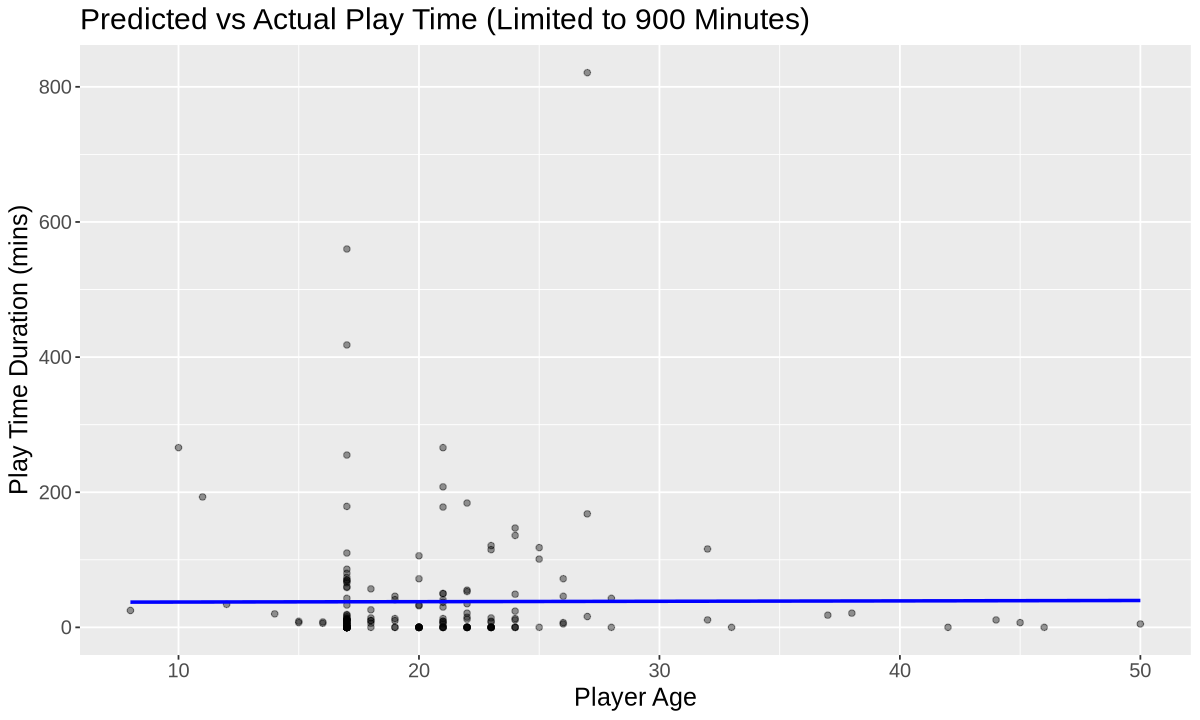

In [19]:
options(repr.plot.width = 10, repr.plot.height = 6) 

age_prediction_grid <- tibble(
    age = c(
        combined_data |> select(age) |> min(),
        combined_data |> select(age) |> max()
    )
)

data_preds <- lm_fit |>
  predict(age_prediction_grid) |>
  bind_cols(age_prediction_grid)

lm_plot_final <- ggplot(combined_data, aes(x = age, y = total_duration_min)) +
  geom_point(alpha = 0.4) +
  geom_line(data = data_preds,
            mapping = aes(x = age, y = .pred),
            color = "blue",
            linewidth = 1) +
  xlab("Player Age") +
  ylab("Play Time Duration (mins)") +
  ggtitle("Predicted vs Actual Play Time (Limited to 900 Minutes)")+
  theme(text = element_text(size = 15))

lm_plot_final

Because we used linear regression, we can quantify the relationship with a mathematical equation explaining that the predictor affects the predictions. The coefficients of the line can be found with the `extract_fit_parsnip()` function.

In [20]:
coeffs <- lm_fit |>
             extract_fit_parsnip() |>
             tidy()
coeffs 

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),36.86973745,28.302529,1.30270117,0.1949111
age,0.05762485,1.320108,0.04365161,0.9652471


Extracting the coefficients from the model, we can find that the equation of the regression line is:

$Play Time = 0.0576(Player Age) + 36.8697$

The equation shows that the model predicts that playtime starts at 36.9 minutes for age 0 and that with every increasing age, the play time of the player increases by 0.0576 minutes. 

## Discussion